In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load data
results_path = Path('../../../results/all/experiment_results.csv')
df = pd.read_csv(results_path)

# Filter for real datasets
real_datasets = ['bank_marketing', 'breast_cancer', 'credit_default', 'pima']
df_real = df[df['dataset_id'].isin(real_datasets)]

print(f"Loaded {len(df_real)} real experiments")
print(f"Methods: {df_real['model_name'].unique()}")
print(f"Datasets: {df_real['dataset_id'].unique()}")

Loaded 300 real experiments
Methods: ['lasso' 'lassonet' 'nimo' 'random_forest' 'neural_net']
Datasets: ['breast_cancer' 'pima' 'bank_marketing']


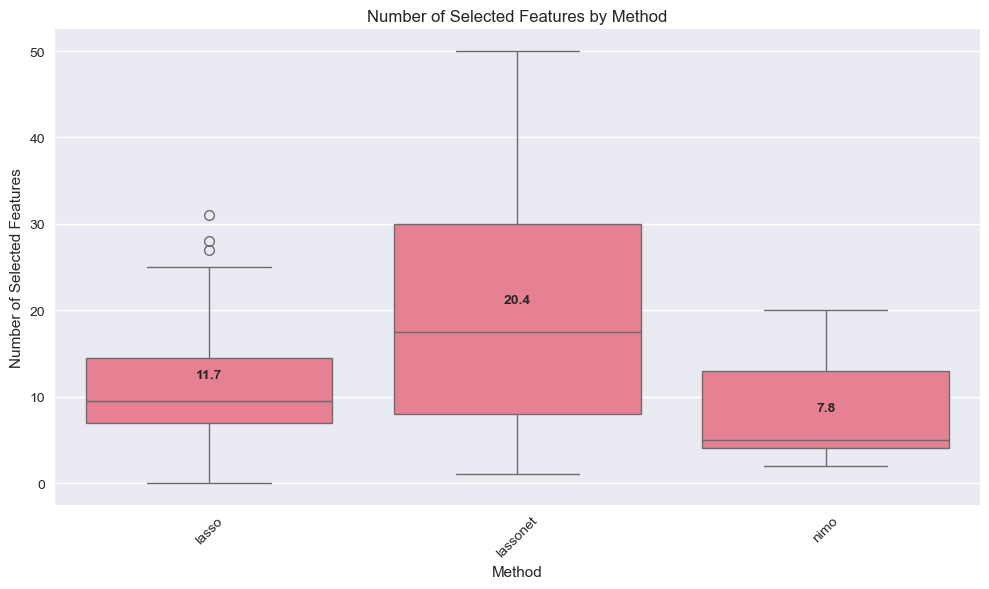


=== FEATURE SELECTION SUMMARY (True Feature Selection Methods Only) ===
             mean    std  min  max
model_name                        
lasso       11.72   6.86    0   31
lassonet    20.35  14.93    1   50
nimo         7.85   5.35    2   20

=== EXCLUDED METHODS ===
Neural Network: Uses all features, no feature selection
Random Forest: Uses all features, 'n_selected' based on importance threshold > 0.01
These methods are excluded as they don't perform true feature selection.


In [6]:
# 1. Feature Selection Counts by Method (True Feature Selection Only)
plt.figure(figsize=(10, 6))

# Filter for methods that do true feature selection
feature_selection_methods = ['lasso', 'lassonet', 'nimo']
df_feature_selection = df_real[df_real['model_name'].isin(feature_selection_methods)]

# Create boxplot for number of selected features
sns.boxplot(data=df_feature_selection, x='model_name', y='n_selected')
plt.title('Number of Selected Features by Method')
plt.xlabel('Method')
plt.ylabel('Number of Selected Features')
plt.xticks(rotation=45)

# Add mean values as text
means = df_feature_selection.groupby('model_name')['n_selected'].mean()
for i, (method, mean) in enumerate(means.items()):
    plt.text(i, mean + 0.1, f'{mean:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== FEATURE SELECTION SUMMARY (True Feature Selection Methods Only) ===")
selection_summary = df_feature_selection.groupby('model_name')['n_selected'].agg(['mean', 'std', 'min', 'max']).round(2)
print(selection_summary)

print("\n=== EXCLUDED METHODS ===")
print("Neural Network: Uses all features, no feature selection")
print("Random Forest: Uses all features, 'n_selected' based on importance threshold > 0.01")
print("These methods are excluded as they don't perform true feature selection.")


LASSO vs NIMO COEFFICIENT COMPARISON (REAL DATASETS)

Dataset bank_marketing:
  Features selected by Lasso/NIMO: [0, 2, 3, 5, 8, 14, 15, 16, 20, 21, 27, 28, 42, 44, 46, 48]
  Features: ['intercept', 'f0', 'f2', 'f3', 'f5', 'f8', 'f14', 'f15', 'f16', 'f20', 'f21', 'f27', 'f28', 'f42', 'f44', 'f46', 'f48']


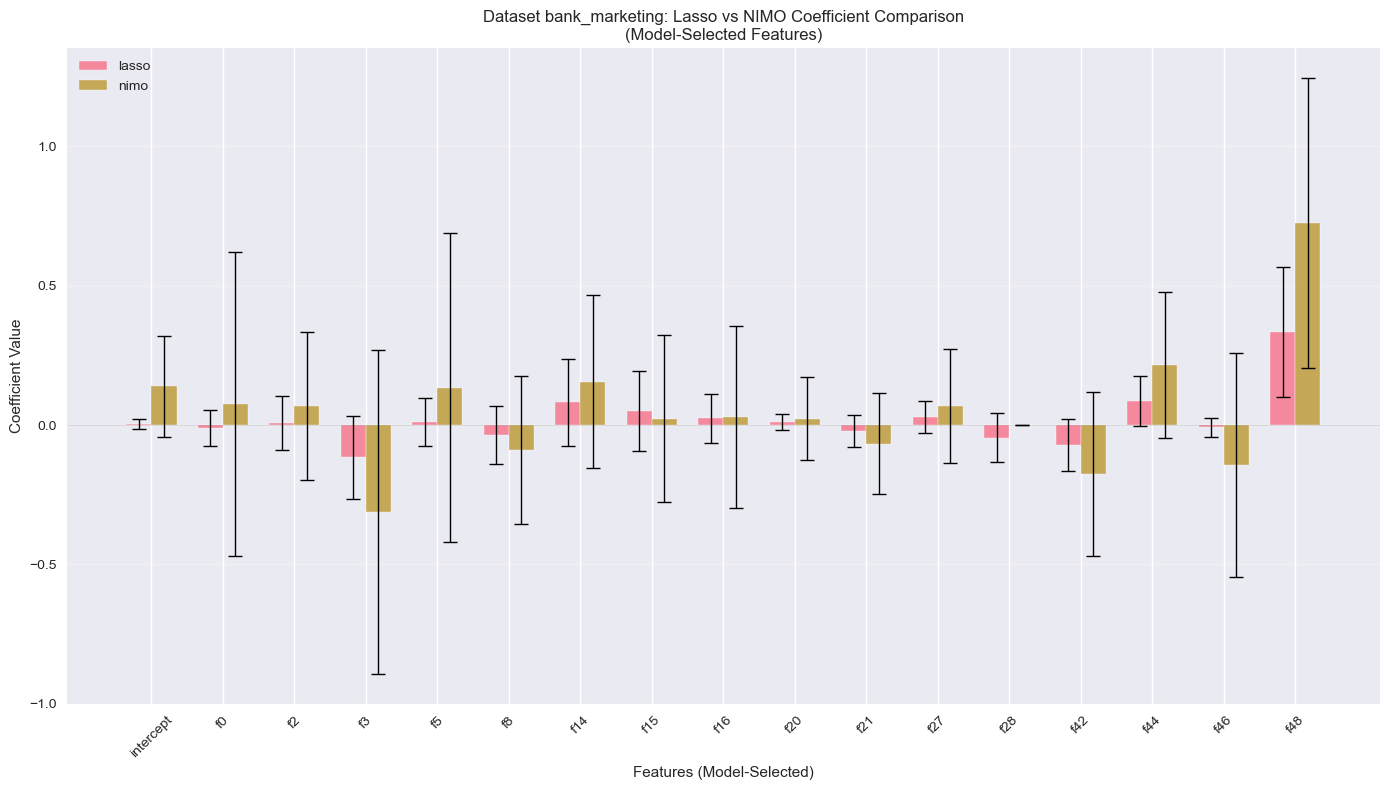


--- DATASET bank_marketing - BEST ITERATION COEFFICIENTS ---
LASSO: Best iteration 7 (F1: 0.672) - 9 features selected
NIMO: Best iteration 16 (F1: 0.662) - 12 features selected


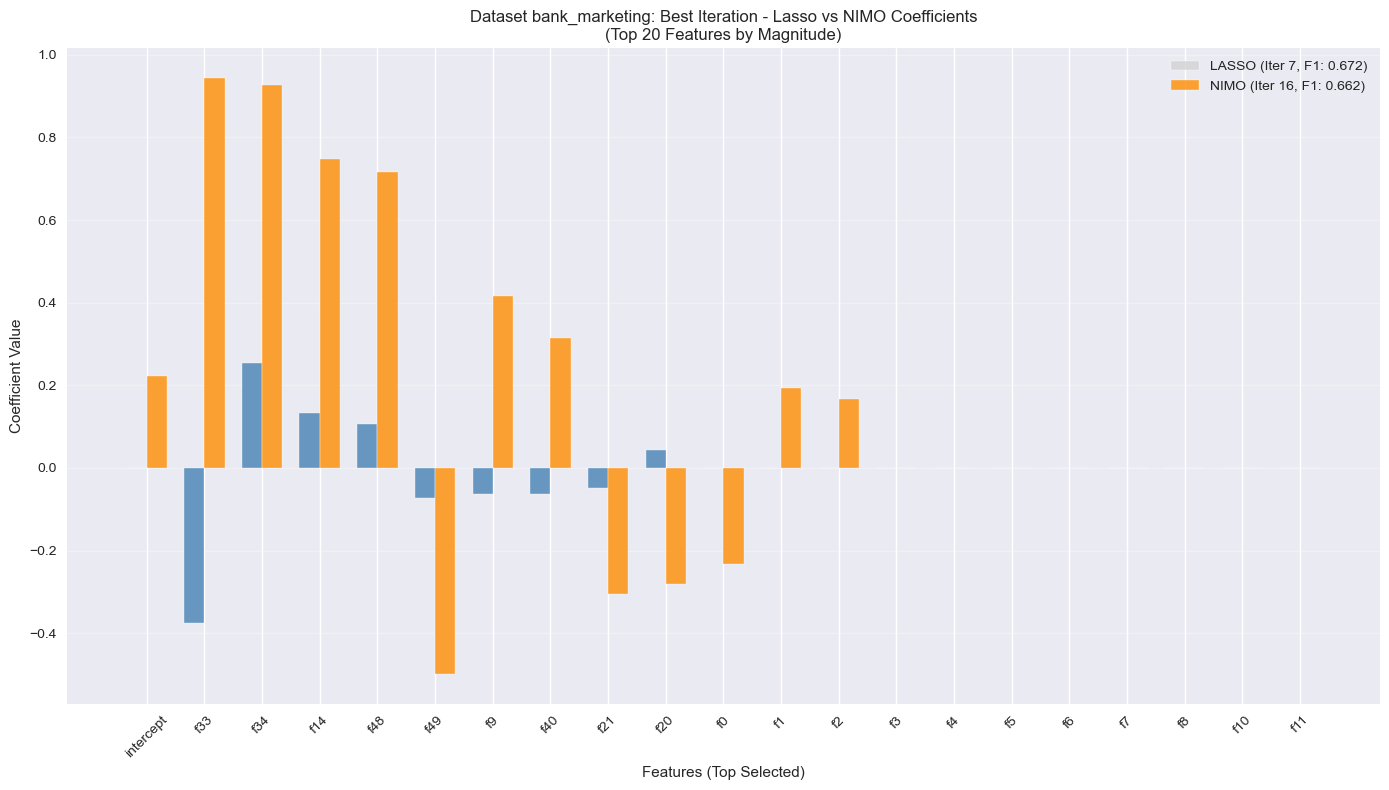


Best iterations:
  LASSO: Iteration 7 (F1: 0.672)
  NIMO: Iteration 16 (F1: 0.662)


Dataset breast_cancer:
  Features selected by Lasso/NIMO: [4, 6, 7, 8, 9, 11, 14, 19, 20, 21, 24, 26, 27, 28]
  Features: ['intercept', 'f4', 'f6', 'f7', 'f8', 'f9', 'f11', 'f14', 'f19', 'f20', 'f21', 'f24', 'f26', 'f27', 'f28']


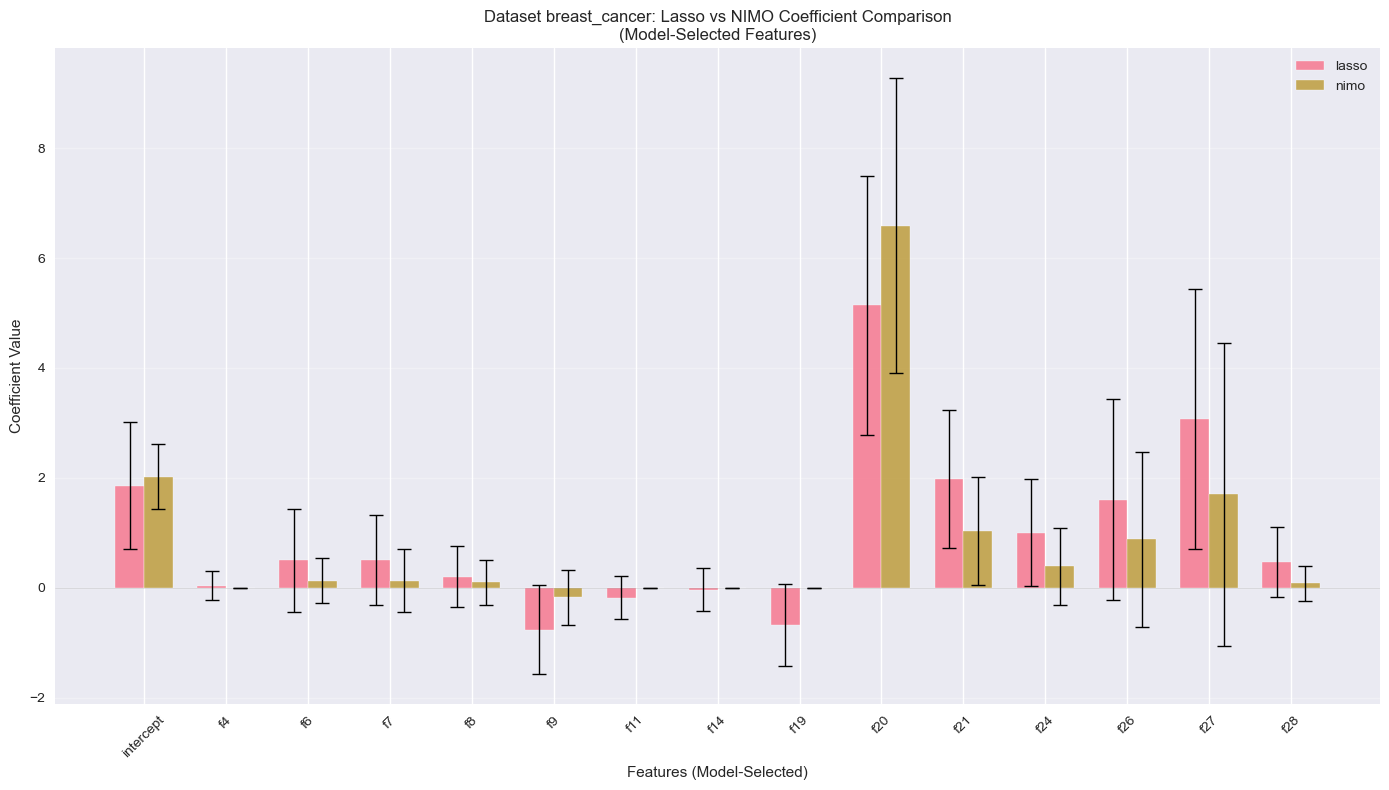


--- DATASET breast_cancer - BEST ITERATION COEFFICIENTS ---
LASSO: Best iteration 11 (F1: 0.951) - 10 features selected
NIMO: Best iteration 4 (F1: 0.952) - 5 features selected


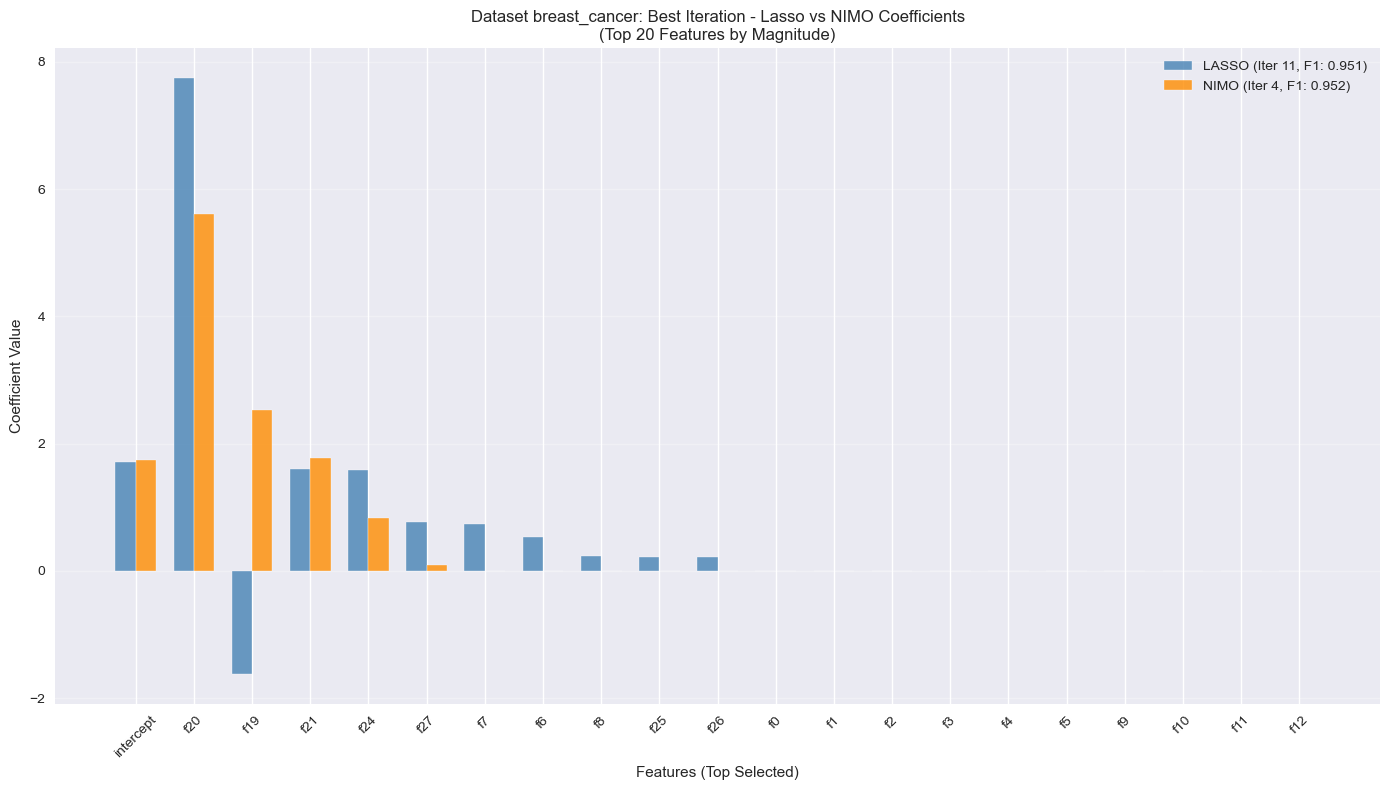


Best iterations:
  LASSO: Iteration 11 (F1: 0.951)
  NIMO: Iteration 4 (F1: 0.952)


Dataset credit_default:
  Features selected by Lasso/NIMO: []
  Features: ['intercept']

Dataset pima:
  Features selected by Lasso/NIMO: [0, 1, 2, 3, 4, 6, 7]
  Features: ['intercept', 'f0', 'f1', 'f2', 'f3', 'f4', 'f6', 'f7']


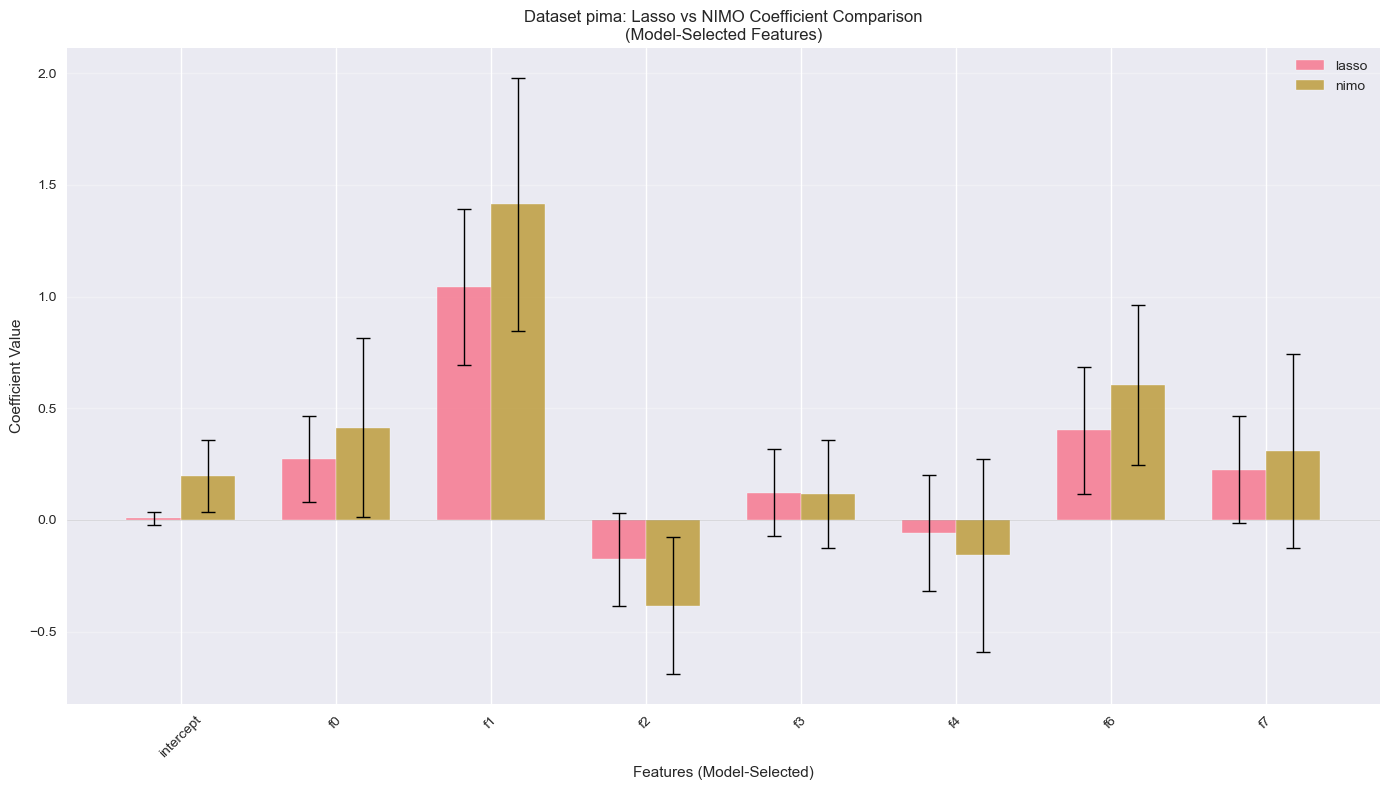


--- DATASET pima - BEST ITERATION COEFFICIENTS ---
LASSO: Best iteration 1 (F1: 0.678) - 6 features selected
NIMO: Best iteration 8 (F1: 0.675) - 4 features selected


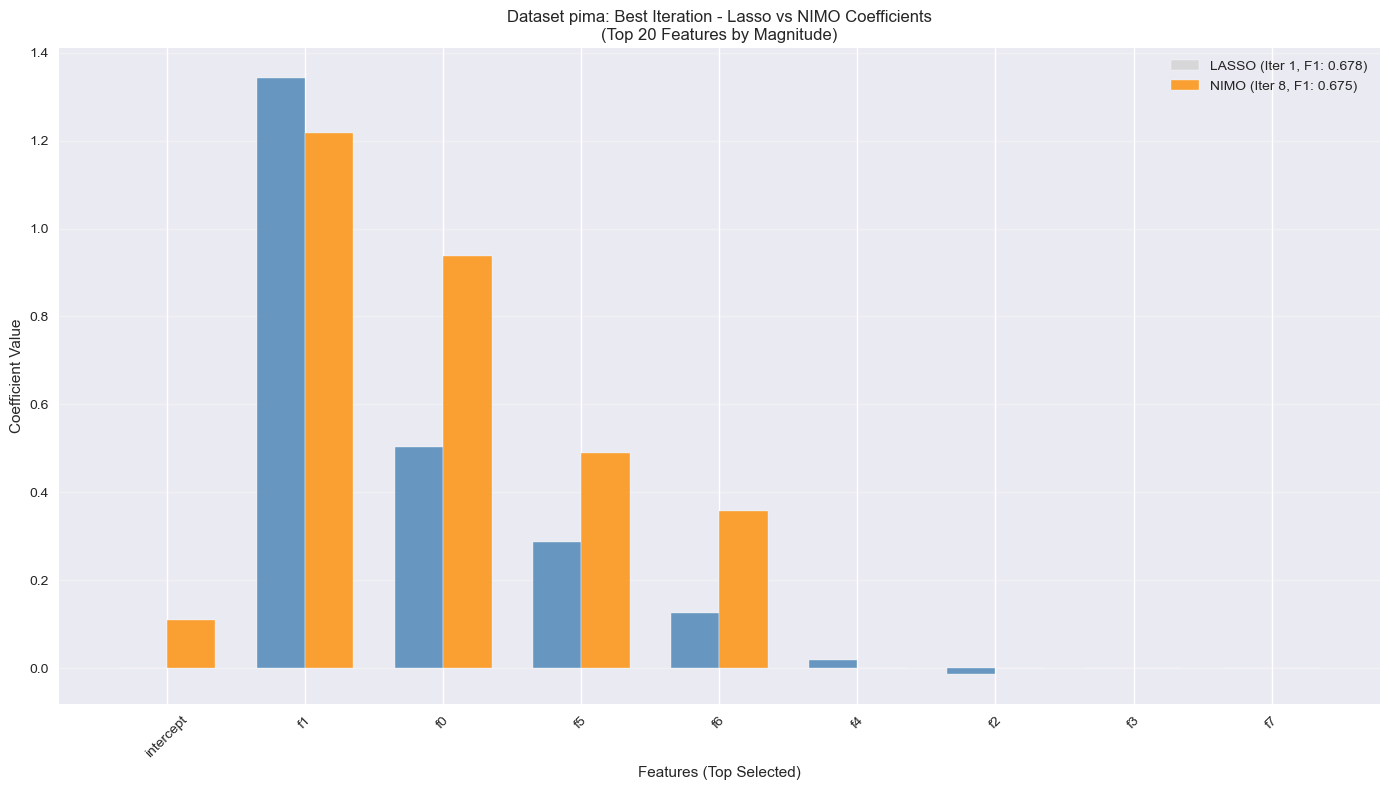


Best iterations:
  LASSO: Iteration 1 (F1: 0.678)
  NIMO: Iteration 8 (F1: 0.675)



In [8]:
# 3. Lasso vs NIMO Coefficients Comparison (Real Datasets)

print("\n" + "=" * 80)
print("LASSO vs NIMO COEFFICIENT COMPARISON (REAL DATASETS)")
print("=" * 80)

TOPK = 20  # Number of top features to show

for dataset in real_datasets:
    print(f"\nDataset {dataset}:")
    
    # Get features selected by Lasso and NIMO
    model_selected_features = set()
    for m in ['lasso', 'nimo']:
        sub = df_real[(df_real["dataset_id"] == dataset) & (df_real["model_name"] == m)]
        if len(sub) > 0:
            coefs_dict = json.loads(sub.iloc[0]["coefficients"])
            coefs = coefs_dict.get("values", [])
            if coefs:
                non_zero_idx = np.where(np.array(coefs) != 0)[0]
                model_selected_features.update(non_zero_idx)
    
    # Get all important features (selected by either model)
    all_important_features = sorted(list(model_selected_features))
    
    # Take top features by frequency of selection
    top_idx = all_important_features[:min(TOPK, len(all_important_features))]
    
    # Add intercept as first column
    labels = ["intercept"] + [f"f{j}" for j in top_idx]
    
    print(f"  Features selected by Lasso/NIMO: {sorted(list(model_selected_features))}")
    print(f"  Features: {labels}")

    # Collect coefficients from ALL iterations for error bar calculation
    all_coefs = {model: [] for model in ['lasso', 'nimo']}

    for m in ['lasso', 'nimo']:
        sub = df_real[(df_real["dataset_id"] == dataset) & (df_real["model_name"] == m)]
        if len(sub) == 0:
            continue
            
        for _, model_row in sub.iterrows():
            try:
                coefs_dict = json.loads(model_row["coefficients"])
                coefs = coefs_dict.get("values", [])
                
                if coefs and len(coefs) > 0:
                    # Get intercept and feature coefficients
                    intercept = coefs_dict.get("intercept", 0.0)
                    coefs_array = np.array(coefs)[top_idx]
                    # Combine intercept and feature coefficients
                    coefs_with_intercept = np.concatenate([[intercept], coefs_array])
                    all_coefs[m].append(coefs_with_intercept)
                    
            except Exception as e:
                print(f"Warning: Could not parse coefficients for {m}: {e}")
                continue

    # Calculate means and standard errors for each model
    model_means = {}
    model_stds = {}
    
    for m in ['lasso', 'nimo']:
        if len(all_coefs[m]) > 0:
            coefs_matrix = np.array(all_coefs[m])  # Shape: (n_iterations, n_features)
            model_means[m] = np.mean(coefs_matrix, axis=0)
            model_stds[m] = np.std(coefs_matrix, axis=0)
        else:
            print(f"Warning: No valid coefficients for {m} in dataset {dataset}")

    # Plot coefficient comparison if we have valid data
    if len(model_means) > 0:
        plt.figure(figsize=(14, 8))
        
        x = np.arange(len(labels))
        width = 0.35  # Width of bars
        
        plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3, linewidth=0.5)
        
        # Plot bars for each model
        for i, (model, means) in enumerate(model_means.items()):
            stds = model_stds[model]
            x_pos = x + i * width - width/2  # Offset bars
            bars = plt.bar(x_pos, means, width, 
                          label=f'{model}', 
                          alpha=0.8,
                          yerr=stds, 
                          capsize=5,
                          error_kw={'elinewidth': 1, 'capthick': 1})
        
        plt.xlabel('Features (Model-Selected)')
        plt.ylabel('Coefficient Value')
        plt.title(f'Dataset {dataset}: Lasso vs NIMO Coefficient Comparison\n(Model-Selected Features)')
        plt.xticks(x, labels, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        
        # ===== BEST ITERATION PLOT =====
        print(f"\n--- DATASET {dataset} - BEST ITERATION COEFFICIENTS ---")
        
        # Find best iteration for each model (Lasso and NIMO)
        best_iterations = {}
        for m in ['lasso', 'nimo']:
            sub = df_real[(df_real["dataset_id"] == dataset) & (df_real["model_name"] == m)]
            if len(sub) > 0:
                f1_scores = sub['f1'].dropna()
                if len(f1_scores) > 0:
                    best_idx = f1_scores.idxmax()
                    best_iterations[m] = sub.loc[best_idx]
                else:
                    best_iterations[m] = sub.iloc[0]  # Fallback to first iteration
        
        # Get coefficients from best iterations
        best_coefs = {}
        best_feature_labels = None
        
        for m in ['lasso', 'nimo']:
            if m in best_iterations:
                best_iter = best_iterations[m]
                try:
                    coefs_dict = json.loads(best_iter["coefficients"])
                    coefs = coefs_dict.get("values", [])
                    if len(coefs) > 0:
                        coefs_array = np.array(coefs)
                        
                        # Get top features by magnitude
                        top_features_by_magnitude = sorted(range(len(coefs_array)), 
                                                         key=lambda i: abs(coefs_array[i]), 
                                                         reverse=True)[:TOPK]
                        
                        # Add intercept as first element
                        intercept = coefs_dict.get("intercept", 0.0)
                        best_coefs[m] = np.concatenate([[intercept], coefs_array[top_features_by_magnitude]])
                        
                        if best_feature_labels is None:
                            best_feature_labels = ["intercept"] + [f"f{i}" for i in top_features_by_magnitude]
                        
                        print(f"{m.upper()}: Best iteration {best_iter['iteration']} (F1: {best_iter['f1']:.3f}) - {np.sum(coefs_array != 0)} features selected")
                except Exception as e:
                    print(f"Warning: Could not parse coefficients for {m}: {e}")
        
        # Plot best iteration coefficients if we have data
        if len(best_coefs) > 0 and best_feature_labels is not None:
            plt.figure(figsize=(14, 8))
            
            x = np.arange(len(best_feature_labels))
            width = 0.35
            
            # Plot bars for each model's best iteration
            for i, (model, coefs) in enumerate(best_coefs.items()):
                best_iter = best_iterations[model]
                x_pos = x + i * width - width/2
                
                # Use different colors for selected vs non-selected features
                base_color = 'steelblue' if model == 'lasso' else 'darkorange'
                colors = [base_color if abs(c) > 1e-6 else 'lightgray' for c in coefs]
                
                bars = plt.bar(x_pos, coefs, width, 
                              label=f'{model.upper()} (Iter {best_iter["iteration"]}, F1: {best_iter["f1"]:.3f})', 
                              color=colors, alpha=0.8)
            
            plt.xlabel('Features (Top Selected)')
            plt.ylabel('Coefficient Value')
            plt.title(f'Dataset {dataset}: Best Iteration - Lasso vs NIMO Coefficients\n(Top {TOPK} Features by Magnitude)')
            plt.xticks(x, best_feature_labels, rotation=45)
            plt.legend()
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()
            
            # Show which iterations had best performance
            print(f"\nBest iterations:")
            for m in ['lasso', 'nimo']:
                if m in best_iterations:
                    best_iter = best_iterations[m]
                    print(f"  {m.upper()}: Iteration {best_iter['iteration']} (F1: {best_iter['f1']:.3f})")
        
        print(f"\n{'='*80}")